<a href="https://colab.research.google.com/github/David-Henry78/davidhenry/blob/master/Fifa_World_Cup_2022_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyspark --quiet
!pip install -U -q PyDrive --quiet
!apt install openjdk-8-jdk-headless &> /dev/null

     |████████████████████████████████| 281.3 MB 46 kB/s 
     |████████████████████████████████| 199 kB 49.0 MB/s 


In [ ]:
!pip install xgboost --quiet

In [ ]:
import zipfile
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import os
from sklearn import metrics
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)
import matplotlib.pyplot as plt
%matplotlib inline
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql import functions as F
from pyspark.sql import types as T
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.mllib.stat import Statistics

Mounted at /content/drive/


In [ ]:
# with zipfile.ZipFile('/content/archive (1).zip', 'r') as zip_ref:
#     zip_ref.extractall('/content/')

In [ ]:
spark = SparkSession.builder.appName("Fifa-World-Cup-2022-Prediction").getOrCreate()

Exploratory Data Analysis (EDA)

international matches dataset

In [ ]:
# SPARK
matchesp = spark.read.csv("/content/drive/MyDrive/Colab-Notebooks/international_matches.csv", header=True, inferSchema=True)
matchesp.columns
# matchesp.show(5)

# PANDAS
# matchesd = pd.read_csv("/content/drive/MyDrive/Colab-Notebooks/international_matches.csv")
# matchesd.head()

['date',
 'home_team',
 'away_team',
 'home_team_continent',
 'away_team_continent',
 'home_team_fifa_rank',
 'away_team_fifa_rank',
 'home_team_total_fifa_points',
 'away_team_total_fifa_points',
 'home_team_score',
 'away_team_score',
 'tournament',
 'city',
 'country',
 'neutral_location',
 'shoot_out',
 'home_team_result',
 'home_team_goalkeeper_score',
 'away_team_goalkeeper_score',
 'home_team_mean_defense_score',
 'home_team_mean_offense_score',
 'home_team_mean_midfield_score',
 'away_team_mean_defense_score',
 'away_team_mean_offense_score',
 'away_team_mean_midfield_score']

world cup 2022 schedule dataset

In [ ]:
# SPARK
gamesp = spark.read.csv("/content/drive/MyDrive/Colab-Notebooks/Fifa worldcup 2022 Dataset.csv", header=True, inferSchema=True)
gamesp = gamesp.dropna(how='all')
gamesp.show(5)

# PANDAS
gamesd = pd.read_csv("/content/drive/MyDrive/Colab-Notebooks/Fifa worldcup 2022 Dataset.csv")
gamesd = gamesd.loc[:, ['Team', 'Group', 'First match against', 'Second match against', 'Third match against']]
gamesd = gamesd.dropna(how='all')
gamesd = gamesd.set_index('Team')
gamesd.head()

+-----------+-----+-------------------+--------------------+-------------------+
|       Team|Group|First match against|Second match against|Third match against|
+-----------+-----+-------------------+--------------------+-------------------+
|      Qatar|    A|            Ecuador|             Senegal|        Netherlands|
|    Ecuador|    A|              Qatar|         Netherlands|            Senegal|
|    Senegal|    A|        Netherlands|               Qatar|            Ecuador|
|Netherlands|    A|            Senegal|             Ecuador|              Qatar|
|    England|    B|            IR Iran|                 USA|              Wales|
+-----------+-----+-------------------+--------------------+-------------------+
only showing top 5 rows



,Group,First match against,Second match against,Third match against
Team,,,,
Qatar,A,Ecuador,Senegal,Netherlands
Ecuador,A,Qatar,Netherlands,Senegal
Senegal,A,Netherlands,Qatar,Ecuador
Netherlands,A,Senegal,Ecuador,Qatar
England,B,IR Iran,USA,Wales


In [ ]:
matchesp.show(1)

+-------------------+---------+---------+-------------------+-------------------+-------------------+-------------------+---------------------------+---------------------------+---------------+---------------+--------------------+------+-------+----------------+---------+----------------+--------------------------+--------------------------+----------------------------+----------------------------+-----------------------------+----------------------------+----------------------------+-----------------------------+
|               date|home_team|away_team|home_team_continent|away_team_continent|home_team_fifa_rank|away_team_fifa_rank|home_team_total_fifa_points|away_team_total_fifa_points|home_team_score|away_team_score|          tournament|  city|country|neutral_location|shoot_out|home_team_result|home_team_goalkeeper_score|away_team_goalkeeper_score|home_team_mean_defense_score|home_team_mean_offense_score|home_team_mean_midfield_score|away_team_mean_defense_score|away_team_mean_offen

In [ ]:
matchesp.dtypes

In [ ]:
# change timestamp to datetime. rename and select relevant columns
matchesp = matchesp.withColumn("date", to_date("date")).withColumnRenamed(
    "home_team_fifa_rank", "home_rank").withColumnRenamed("away_team_fifa_rank", "away_rank").withColumnRenamed(
        "home_team_result", "home_result").withColumnRenamed("home_team_total_fifa_points", "home_points").withColumnRenamed(
            "away_team_total_fifa_points", "away_points").withColumnRenamed("home_team_score", "home_score").withColumnRenamed(
                "away_team_score", "away_score").withColumnRenamed("home_team", "home").withColumnRenamed("away_team", "away")
matchesp.show(1)
matchesp = matchesp.select("date", "home", "away", "home_rank", "away_rank", "home_points", "away_points", "home_score", "away_score", "tournament", "neutral_location", "home_result")

+----------+-------+-------+-------------------+-------------------+---------+---------+-----------+-----------+----------+----------+--------------------+------+-------+----------------+---------+-----------+--------------------------+--------------------------+----------------------------+----------------------------+-----------------------------+----------------------------+----------------------------+-----------------------------+
|      date|   home|   away|home_team_continent|away_team_continent|home_rank|away_rank|home_points|away_points|home_score|away_score|          tournament|  city|country|neutral_location|shoot_out|home_result|home_team_goalkeeper_score|away_team_goalkeeper_score|home_team_mean_defense_score|home_team_mean_offense_score|home_team_mean_midfield_score|away_team_mean_defense_score|away_team_mean_offense_score|away_team_mean_midfield_score|
+----------+-------+-------+-------------------+-------------------+---------+---------+-----------+-----------+--------

In [ ]:
# Create integer representation of categorical column for correlation purpose
matchesp = matchesp.withColumn("home_result", F.when(F.col("home_result") == "Win", 3).when(F.col("home_result") == "Draw", 1).otherwise(0))
matchesp.show(8)
matchesp.select("home_result").dtypes

+----------+--------+------------+---------+---------+-----------+-----------+----------+----------+--------------------+----------------+-----------+
|      date|    home|        away|home_rank|away_rank|home_points|away_points|home_score|away_score|          tournament|neutral_location|home_result|
+----------+--------+------------+---------+---------+-----------+-----------+----------+----------+--------------------+----------------+-----------+
|1993-08-08| Bolivia|     Uruguay|       59|       22|          0|          0|         3|         1|FIFA World Cup qu...|           false|          3|
|1993-08-08|  Brazil|      Mexico|        8|       14|          0|          0|         1|         1|            Friendly|           false|          1|
|1993-08-08| Ecuador|   Venezuela|       35|       94|          0|          0|         5|         0|FIFA World Cup qu...|           false|          3|
|1993-08-08|  Guinea|Sierra Leone|       65|       86|          0|          0|         1|     

[('home_result', 'int')]

Correlation of international matches

In [ ]:
matchesp_corr = matchesp.toPandas()
matchesp_corr.head(2)

,date,home,away,home_rank,away_rank,home_points,away_points,home_score,away_score,tournament,neutral_location,home_result
0,1993-08-08,Bolivia,Uruguay,59,22,0,0,3,1,FIFA World Cup qualification,False,3
1,1993-08-08,Brazil,Mexico,8,14,0,0,1,1,Friendly,False,1


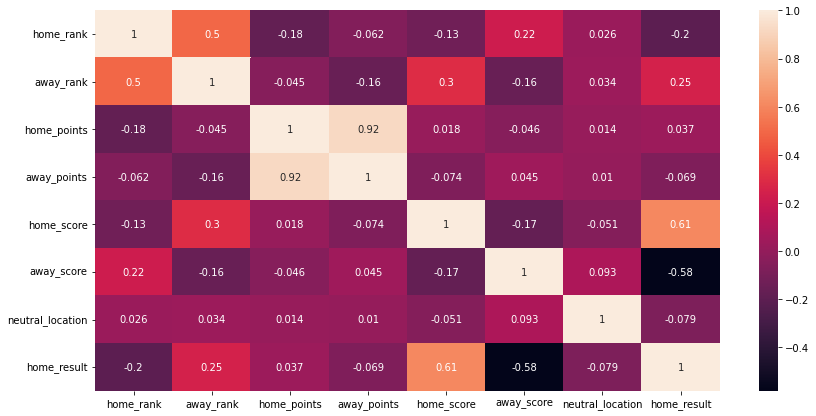

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(14, 7)
corr1 = matchesp_corr.corr()
sns.heatmap(corr1,annot=True)

Feature Generation Pandas

In [ ]:
matchesd = pd.DataFrame(matchesp_corr)
matchesd["rank_diff"] = matchesd["home_rank"] - matchesd["away_rank"]
matchesd["rank_avg"] = (matchesd["home_rank"] + matchesd['away_rank']) / 2
matchesd["point_diff"] = matchesd["home_points"] - matchesd['away_points']
matchesd["stake"] = matchesd['tournament'] != 'Friendly'
matchesd.head()

,date,home,away,home_rank,away_rank,home_points,away_points,home_score,away_score,tournament,neutral_location,home_result,rank_diff,rank_avg,point_diff,stake
0,1993-08-08,Bolivia,Uruguay,59,22,0,0,3,1,FIFA World Cup qualification,False,3,37,40.5,0,True
1,1993-08-08,Brazil,Mexico,8,14,0,0,1,1,Friendly,False,1,-6,11.0,0,False
2,1993-08-08,Ecuador,Venezuela,35,94,0,0,5,0,FIFA World Cup qualification,False,3,-59,64.5,0,True
3,1993-08-08,Guinea,Sierra Leone,65,86,0,0,1,0,Friendly,False,3,-21,75.5,0,False
4,1993-08-08,Paraguay,Argentina,67,5,0,0,1,3,FIFA World Cup qualification,False,0,62,36.0,0,True


In [ ]:
features = matchesd[["rank_diff", "point_diff", "neutral_location", "rank_avg", "stake"]]
features.head()

,rank_diff,point_diff,neutral_location,rank_avg,stake
0,37,0,False,40.5,True
1,-6,0,False,11.0,False
2,-59,0,False,64.5,True
3,-21,0,False,75.5,False
4,62,0,False,36.0,True


Feature Generation PySpark

In [ ]:
#first way
matchesp.show(1)
features_spark = spark.createDataFrame(matchesd)
features_spark.show(2)

+----------+-------+-------+---------+---------+-----------+-----------+----------+----------+--------------------+----------------+-----------+
|      date|   home|   away|home_rank|away_rank|home_points|away_points|home_score|away_score|          tournament|neutral_location|home_result|
+----------+-------+-------+---------+---------+-----------+-----------+----------+----------+--------------------+----------------+-----------+
|1993-08-08|Bolivia|Uruguay|       59|       22|          0|          0|         3|         1|FIFA World Cup qu...|           false|          3|
+----------+-------+-------+---------+---------+-----------+-----------+----------+----------+--------------------+----------------+-----------+
only showing top 1 row

+----------+-------+-------+---------+---------+-----------+-----------+----------+----------+--------------------+----------------+-----------+---------+--------+----------+-----+
|      date|   home|   away|home_rank|away_rank|home_points|away_point

In [ ]:
#second way
matchesp = matchesp.withColumn("rank_diff", matchesp["home_rank"] - matchesp["away_rank"])
matchesp = matchesp.withColumns({"rank_avg": (matchesp["home_rank"] + matchesp["away_rank"]) / 2,
                                 "point_diff": matchesp["home_points"] + matchesp["away_points"],
                                 "stake" : matchesp["tournament"] != "Friendly", "score_diff" : matchesp["home_score"] - matchesp["away_score"]})
matchesp.show(1)
features_sp = matchesp[["rank_diff", "point_diff", "neutral_location", "rank_avg", "stake"]]
features_sp.show(3)

+----------+-------+-------+---------+---------+-----------+-----------+----------+----------+--------------------+----------------+-----------+---------+--------+----------+-----+----------+
|      date|   home|   away|home_rank|away_rank|home_points|away_points|home_score|away_score|          tournament|neutral_location|home_result|rank_diff|rank_avg|point_diff|stake|score_diff|
+----------+-------+-------+---------+---------+-----------+-----------+----------+----------+--------------------+----------------+-----------+---------+--------+----------+-----+----------+
|1993-08-08|Bolivia|Uruguay|       59|       22|          0|          0|         3|         1|FIFA World Cup qu...|           false|          3|       37|    40.5|         0| true|         2|
+----------+-------+-------+---------+---------+-----------+-----------+----------+----------+--------------------+----------------+-----------+---------+--------+----------+-----+----------+
only showing top 1 row

+---------+-----

Define functions for selected features and target

---



In [ ]:
from pyspark.sql.types import StructType
def init_feat(matchesp):
  features_spdf = matchesp[["rank_diff", "point_diff", "neutral_location", "rank_avg", "stake"]]
  # features_spdf2 = matchesp[["home_rank", "away_rank", "home_points", "away_points", "neutral_location"]]
  # schema = StructType(features_spdf2.schema.fields + features_spdf.schema.fields)
  # features_spdf3 = features_spdf2.rdd.zip(features_spdf.rdd).map(lambda x : x[0] + x[1])#matchesp[[ "home_points", "away_points", "neutral_location", "rank_diff", "point_diff", "rank_avg", "stake"]]
  # features_spdf3 = spark.createDataFrame(features_spdf3, schema)
  # cols_new = []
  # seen = set()
  # for c in features_spdf3.columns:
  #   cols_new.append('{}_dup'.format(c) if c in seen else c)
  #   seen.add(c)
  # features_spdf3 = features_spdf3.toDF(*cols_new).select(*[c for c in cols_new if not c.endswith('_dup')])

  # print(cols_new)
  # features_spdf3.show()
  chosen_feat = features_spdf.select("*")
  return chosen_feat

def targ_feat(matchesp):
  chosen_targ = matchesp[["home_result"]]
  return chosen_targ

x = init_feat(matchesp)
y = targ_feat(matchesp)

In [ ]:
x = init_feat(matchesp).collect()
y = targ_feat(matchesp).collect()

Split data and use XGBOOST for training and testing

In [ ]:
import xgboost
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

In [ ]:
# y = matchesp.randomSplit
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3, random_state=0)



In [ ]:
x_train = np.asarray(x_train)
y_train = np.ravel(y_train)

In [ ]:
model = xgboost.XGBClassifier(random_state=0)
model.fit(x_train, y_train)

XGBClassifier(objective='multi:softprob')

In [ ]:
model.score(x_test,y_test)

0.585481398913195

In [ ]:
y_pred = model.predict(x_test)
predictions = np.round(y_pred)
# predictions
u = model.predict_proba(data=x_test)
v = model.predict_proba(data=x_test)[:,2][0]
print(u[:777])
v

[[0.0702607  0.09612789 0.83361137]
 [0.37890688 0.2777806  0.34331253]
 [0.05818325 0.12259782 0.81921893]
 ...
 [0.29858887 0.2772295  0.4241816 ]
 [0.26216552 0.2707526  0.46708184]
 [0.22951345 0.40010914 0.3703774 ]]


0.83361137

In [ ]:
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
w = predictions[775:]
print(w)
count = 0
drawIndex = []
for i, x in enumerate(predictions):
  if x == 1:
    count+=1
    drawIndex.append(i)
print(count)
print(len(drawIndex))
np.asarray(drawIndex)
# drawIndex = array([ 776, 1141, 1270, 1490, 1641, 1936, 2635, 2676, 2874, 3225, 3490,
#        3665, 3724, 3744, 4014, 4109, 4247, 4549, 4712, 5059, 5105, 5142,
#        5537, 6049, 6075, 6114, 6755, 6817, 6957, 7033])

Accuracy: 58.55%
[3 1 0 ... 3 3 3]
30
30


array([ 776, 1141, 1270, 1490, 1641, 1936, 2635, 2676, 2874, 3225, 3490,
       3665, 3724, 3744, 4014, 4109, 4247, 4549, 4712, 5059, 5105, 5142,
       5537, 6049, 6075, 6114, 6755, 6817, 6957, 7033])

Accuracy with K_Fold CV

In [ ]:
model = XGBClassifier(random_state=0)
kfold = KFold(n_splits=10, shuffle=True, random_state=0)
results = cross_val_score(model, x_train, np.ravel(y_train), cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Accuracy with Stratified K_Fold CV

In [ ]:
model = xgboost.XGBClassifier(random_state=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
results = cross_val_score(model, x_train, np.ravel(y_train), cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Importance Of Features

+----------------+-------------------+
|         feature|         importance|
+----------------+-------------------+
|       rank_diff|  0.605817437171936|
|neutral_location|0.16039200127124786|
|           stake|0.11861906200647354|
|        rank_avg|0.06842592358589172|
|      point_diff|0.04674556851387024|
+----------------+-------------------+



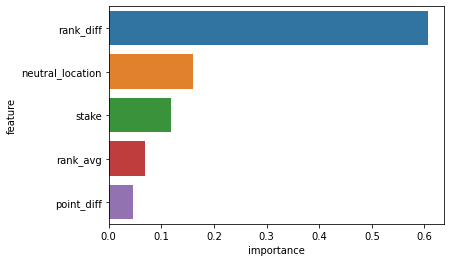

In [ ]:
from pyspark.sql import Row

# def importance_of_features(model):
#     features = [{"feature" : init_feat(matchesp).columns,
#                  "importance" : model.feature_importances_.tolist()}]
#     features_df = spark.createDataFrame(features)
#     features_df = features_df.selectExpr('inline(arrays_zip(*))')
#     features_df = features_df.sort(['importance'], ascending=True, inplace=True)
#     # features_df = features_df.groupBy('feature')
#     features_pd = features_df.toPandas()
#     features_pd.set_index('feature', inplace=True)
#     return features_pd.plot(kind='pie', figsize=(6,6), subplots=True)
# importance_of_features(model)
def importance_of_features(model):
      features = [{"feature" : init_feat(matchesp).columns,
                      "importance" : model.feature_importances_.tolist()}]
      features_df = spark.createDataFrame(features)
      features_df = features_df.selectExpr('inline(arrays_zip(*))')
      features_df = features_df.sort(['importance'], ascending=False, inplace=True)
      features_df.show()
      features_df = features_df.toPandas()
      return sns.barplot(data=features_df, x="importance", y="feature")
importance_of_features(model)

Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
rf = RandomForestClassifier(random_state=0)
rf.fit(x_train, np.ravel(y_train))
y_pred_rf = rf.predict(x_test)
print(metrics.accuracy_score(y_test, y_pred_rf))

from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

In [ ]:
# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 0, stop = 2000, num = 11)]
# # Number of features to consider at every split
# max_features = ['auto', 'sqrt']
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(0, 100, num = 6)]
# max_depth.append(None)
# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]
# # Method of selecting samples for training each tree
# bootstrap = [True, False]
# # Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}
# pprint(random_grid)

# # Use the random grid to search for best hyperparameters
# # First create the base model to tune
# rfc = RandomForestClassifier(random_state=42)
# # Random search of parameters, using 2-fold cross validation,
# # search across 100 different combinations, and use all available cores
# rfc_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 100, cv = 2, verbose=2, n_jobs = -1)
# # Fit the random search model
# rfc_random.fit(x_train, np.ravel(y_train))
# y_pred_rfr_random = rfc_random.predict(x_test)
# print(metrics.accuracy_score(y_test, y_pred_rfr_random))

Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

model = LogisticRegression(random_state=42)
model.fit(x_train, np.ravel(y_train))

In [ ]:
y_pred = model.predict(x_test)
print(metrics.accuracy_score(y_test, y_pred))

In [ ]:
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(model.get_params())

In [ ]:
log_model = LogisticRegression(max_iter=131, verbose=2, random_state=42)
log_model.fit(x_train, np.ravel(y_train))
y_pred_log = log_model.predict(x_test)
print(metrics.accuracy_score(y_test, y_pred_log))

In [ ]:
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of grid search
# Penalty type
penalty = ['l1', 'l2', 'elasticnet', 'none']
# Solver type
solver = ['lbfgs', 'liblinear']
# Maximum number of iterations
max_iter = [int(x) for x in np.linspace(start = 80, stop = 120, num = 5)]
# Multi class
multi_class = ['auto', 'ovr']
# Verbosity
verbose = [0, 1, 2]
# l1 ratio
l1_ratio = [0, 0.8, 0.9, 1]
# C
C = [0.5, 0.75, 1.0, 1.25, 1.5]

# Create the param grid
param_grid = {'penalty': penalty, 'solver': solver, 'max_iter':max_iter,
    'multi_class':multi_class, 'verbose':verbose, 'l1_ratio':l1_ratio,
    'C':C
}
pprint(param_grid)

# Instantiate the grid search model with 2-fold cross-validation
log_grid_search = GridSearchCV(estimator = LogisticRegression(random_state=42), param_grid = param_grid, cv = 2, n_jobs = -1)

# Fit the grid search to the data
log_grid_search.fit(x_train, np.ravel(y_train))
best_log_grid = log_grid_search.best_estimator_
best_log_grid.fit(x_train, np.ravel(y_train))
y_pred_best_log = best_log_grid.predict(x_test)
print(metrics.accuracy_score(y_test, y_pred_best_log))

Gaussian Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(x_train, y_train)

# making predictions on the testing set
y_pred = gnb.predict(x_test)

# comparing actual response values (y_test) with predicted response values (y_pred)
from sklearn import metrics
print("Gaussian Naive Bayes model accuracy(in %):", metrics.accuracy_score(y_test, y_pred)*100)


In [ ]:
nb_classifier = GaussianNB()
kfold = KFold(n_splits=10, shuffle=True, random_state=0)
params_NB = {'var_smoothing': [0.000000035111917342151277]} # {'var_smoothing': np.logspace(0,-9, num=100)}
gs_NB = GridSearchCV(estimator=nb_classifier,
                 param_grid=params_NB,
                 cv=kfold,   # use any cross validation technique
                 verbose=1,
                 scoring='accuracy')
gs_NB.fit(x_train, y_train)

# gs_NB.best_params_

y_pred = gs_NB.predict(x_test)

# comparing actual response values (y_test) with predicted response values (y_pred)
from sklearn import metrics
print("Gaussian Naive Bayes model accuracy(in %):", metrics.accuracy_score(y_test, y_pred)*100)


Using PySpark Vector

In [ ]:
spark_df = matchesp[["rank_diff", "point_diff", "neutral_location", "rank_avg", "stake", "home_result"]]
spark_df.show(3)
(train_df, test_df) = spark_df.randomSplit([0.7, 0.3], 0)

In [ ]:
inputCols = ["rank_diff", "point_diff", "neutral_location", "rank_avg", "stake"]
# inputCols
outputCol = "features"
vector_assembler = VectorAssembler(inputCols=inputCols, outputCol=outputCol)
train_df = vector_assembler.transform(train_df)


In [ ]:
modeling_df = train_df.select(["features", "home_result"])
modeling_df.show(3)

In [ ]:
# from xgboost.spark import SparkXGBClassifier
from pyspark.ml.classification import DecisionTreeClassifier
dtc_model = DecisionTreeClassifier(labelCol="home_result", featuresCol="features")

In [ ]:
dtc_model = dtc_model.fit(modeling_df)

In [ ]:
predictions = dtc_model.transform(modeling_df)
predictions.show(5, truncate=False)

In [ ]:
test_df = vector_assembler.transform(test_df)
test_predictions = dtc_model.transform(test_df)

In [ ]:
test_predictions.show(2, truncate=False)
t = test_predictions.select("prediction").collect()
t = np.array(t)

int(t[5500])
count = 0
tIndex = []
for i, x in enumerate(t):
  if x == 1:
    count+=1
    tIndex.append(i)
print(count)
print(len(tIndex))

In [ ]:
testarr = test_df.select("home_result").collect()
testarr = np.array(testarr)
testarr
acc = accuracy_score(testarr, t)
acc

World Cup 2022 Simulation

In [ ]:
# from pyspark.sql.functions import col, max as max_

matchesp.show(1)
home_nation = matchesp[["date", "home", "home_points", "home_rank"]]
away_nation = matchesp[["date", "away", "away_points", "away_rank"]]
# ranking.show()
fifa_ranking = home_nation.union(away_nation)
fifa_ranking = fifa_ranking.createOrReplaceTempView("entries")

fifa_ranking = spark.sql('''
    SELECT
        *
    FROM (
        SELECT
            *,
            dense_rank() OVER (PARTITION BY home ORDER BY date DESC) AS rank
        FROM entries
    ) vo WHERE rank = 1
''');

fifa_ranking = fifa_ranking.sort("home_points", ascending=False).drop("rank")
fifa_ranking = fifa_ranking.withColumnRenamed("home", "nation").withColumnRenamed("home_points", "total_points").withColumnRenamed("home_rank", "rank")
fifa_ranking.show(5)

+----------+-------+-------+---------+---------+-----------+-----------+----------+----------+--------------------+----------------+-----------+---------+--------+----------+-----+----------+
|      date|   home|   away|home_rank|away_rank|home_points|away_points|home_score|away_score|          tournament|neutral_location|home_result|rank_diff|rank_avg|point_diff|stake|score_diff|
+----------+-------+-------+---------+---------+-----------+-----------+----------+----------+--------------------+----------------+-----------+---------+--------+----------+-----+----------+
|1993-08-08|Bolivia|Uruguay|       59|       22|          0|          0|         3|         1|FIFA World Cup qu...|           false|          3|       37|    40.5|         0| true|         2|
+----------+-------+-------+---------+---------+-----------+-----------+----------+----------+--------------------+----------------+-----------+---------+--------+----------+-----+----------+
only showing top 1 row

+----------+----

In [ ]:
gamesp.show(1)

+-----+-----+-------------------+--------------------+-------------------+
| Team|Group|First match against|Second match against|Third match against|
+-----+-----+-------------------+--------------------+-------------------+
|Qatar|    A|            Ecuador|             Senegal|        Netherlands|
+-----+-----+-------------------+--------------------+-------------------+
only showing top 1 row



In [ ]:
participants = gamesp.groupby('Team').count().drop("count")
participants = participants.sort("Team")

participants.show(3)
# participants.collect()

+---------+
|     Team|
+---------+
|Argentina|
|Australia|
|  Belgium|
+---------+
only showing top 3 rows



In [ ]:
participants_rank = fifa_ranking
part_list = participants.select("Team").collect()
part_list = np.array((part_list)).flatten()
part_list
target = [
    struct(
        lit(nation).alias("nation").cast("string"))
    for nation in part_list]

query = struct("nation").isin(target)
participants_rank = participants_rank.where(query)
# participants_rank = participants_rank.where(col('nation').isin(part_list))
print("Number of participants: ", str(participants_rank.count()))
# hr = participants_rank.select(F.col()where(w))
participants_rank.show(3)
participants_rank_pd = participants_rank.toPandas().set_index("nation")
participants_rank_pd.head(3)

Number of participants:  32
+----------+-------+------------+----+
|      date| nation|total_points|rank|
+----------+-------+------------+----+
|2022-06-06| Brazil|        1832|   1|
|2022-06-14|Belgium|        1827|   2|
|2022-06-13| France|        1789|   3|
+----------+-------+------------+----+
only showing top 3 rows



,date,total_points,rank
nation,,,
Brazil,2022-06-06,1832,1
Belgium,2022-06-14,1827,2
France,2022-06-13,1789,3


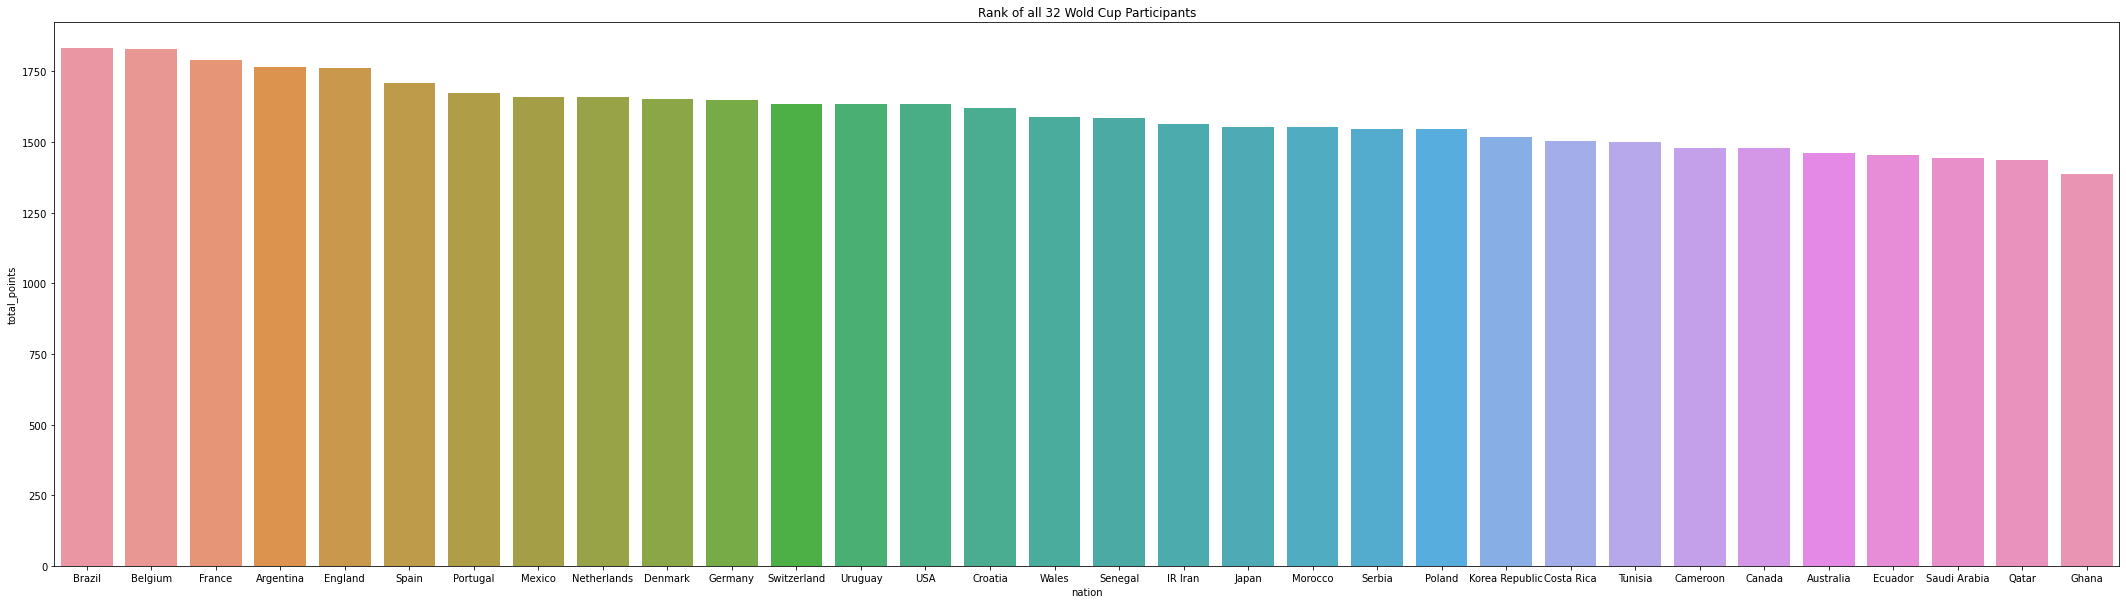

In [ ]:
plt.figure(figsize=(37,10))
plt.title("Rank of all 32 Wold Cup Participants")
sns.barplot(data=participants_rank.toPandas(), x='nation',y='total_points')

Group Stage

In [ ]:
from itertools import combinations
# Using Pandas
world_cup = gamesd
world_cup.head()

,Group,First match against,Second match against,Third match against,points,total_prob
Team,,,,,,
Qatar,A,Ecuador,Senegal,Netherlands,3,1.097558
Ecuador,A,Qatar,Netherlands,Senegal,0,0.782787
Senegal,A,Netherlands,Qatar,Ecuador,6,1.222015
Netherlands,A,Senegal,Ecuador,Qatar,9,1.416371
England,B,IR Iran,USA,Wales,9,1.597103


In [ ]:
world_cup['points'] = 0
world_cup['total_prob'] = 0
features.columns

Index(['rank_diff', 'point_diff', 'neutral_location', 'rank_avg', 'stake'], dtype='object')

In [ ]:
import builtins as bts
for group in set(world_cup['Group']):
    print('___Starting group {}:___'.format(group))
    for home, away in combinations(world_cup.query('Group == "{}"'.format(group)).index, 2):
        print("{} vs. {}: ".format(home, away), end='')
        # columns = features.columns
        row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan, np.nan,np.nan]]), columns=init_feat(matchesp).columns)
        home_rank = participants_rank.select("rank").where(participants_rank.nation == home).collect()[0][0] # participants_rank_pd.loc[home,"rank"]
        away_rank = participants_rank.select("rank").where(participants_rank.nation == away).collect()[0][0] # participants_rank_pd.loc[away,"rank"]

        row["rank_diff"] = home_rank - away_rank
        row["point_diff"] = participants_rank_pd.loc[home,"total_points"] - participants_rank_pd.loc[away,"total_points"]
        row["neutral_location"] = False if home == "Qatar" else True
        row["rank_avg"] = (home_rank + away_rank) / 2
        row['stake'] = True

        row = spark.createDataFrame(row)
        row = np.asarray(row.collect())

        home_win_prob = model.predict_proba(row)[:,2][0]
        away_win_prob = model.predict_proba(row)[:,0][0]
        draw_prob = model.predict_proba(row)[:,1][0]

        points = 0
        probability = bts.max(home_win_prob,away_win_prob,draw_prob)
        if probability == away_win_prob:
          print("{} wins with a probability of {:.2f}% ".format(away, away_win_prob))
          world_cup.loc[away, 'points'] += 3
          world_cup.loc[home, 'total_prob'] += home_win_prob
          world_cup.loc[away, 'total_prob'] += away_win_prob
        if probability == draw_prob:
            points = 1
            print("Draw with probability of {:.2f}%".format(draw_prob))
            world_cup.loc[home, 'points'] += 1
            world_cup.loc[away, 'points'] += 1
            world_cup.loc[home, 'total_prob'] += draw_prob
            world_cup.loc[away, 'total_prob'] += draw_prob
        if probability == home_win_prob:
            points = 3
            world_cup.loc[home, 'points'] += 3
            world_cup.loc[home, 'total_prob'] += home_win_prob
            world_cup.loc[away, 'total_prob'] += away_win_prob
            print("{} wins with a probability of {:.2f}%".format(home, home_win_prob))

___Starting group C:___
Argentina vs. Saudi Arabia: Argentina wins with a probability of 0.66%
Argentina vs. Mexico: Argentina wins with a probability of 0.45%
Argentina vs. Poland: Argentina wins with a probability of 0.56%
Saudi Arabia vs. Mexico: Mexico wins with a probability of 0.54% 
Saudi Arabia vs. Poland: Poland wins with a probability of 0.48% 
Mexico vs. Poland: Mexico wins with a probability of 0.52%
___Starting group A:___
Qatar vs. Ecuador: Qatar wins with a probability of 0.48%
Qatar vs. Senegal: Senegal wins with a probability of 0.40% 
Qatar vs. Netherlands: Netherlands wins with a probability of 0.43% 
Ecuador vs. Senegal: Senegal wins with a probability of 0.49% 
Ecuador vs. Netherlands: Netherlands wins with a probability of 0.54% 
Senegal vs. Netherlands: Netherlands wins with a probability of 0.45% 
___Starting group F:___
Belgium vs. Canada: Belgium wins with a probability of 0.59%
Belgium vs. Morocco: Belgium wins with a probability of 0.57%
Belgium vs. Croatia:

In [ ]:
world_cup.head(10)

,Group,First match against,Second match against,Third match against,points,total_prob
Team,,,,,,
Qatar,A,Ecuador,Senegal,Netherlands,3,1.097558
Ecuador,A,Qatar,Netherlands,Senegal,0,0.782787
Senegal,A,Netherlands,Qatar,Ecuador,6,1.222015
Netherlands,A,Senegal,Ecuador,Qatar,9,1.416371
England,B,IR Iran,USA,Wales,9,1.597103
IR Iran,B,England,Wales,USA,6,1.030703
USA,B,Wales,England,IR Iran,3,1.093685
Wales,B,USA,IR Iran,England,0,0.962655
Argentina,C,Saudi Arabia,Mexico,Poland,9,1.665174


In [ ]:
# Using PySPark
# world_cup = gamesp
# world_cup = world_cup.withColumns({"points" : lit(0), "total_prob" : lit(0)})
# # world_cup = world_cup.withColumn("points", lit(0))
# world_cup.show(2)



In [ ]:
# # group_set = world_cup.select("Group").collect()
# group_set = set(np.array(world_cup.select("Group").collect()).flatten())
# # group_set = set(group_set)
# # group_set

# for group in set(group_set):
#     print('___Starting group {}:___'.format(group))
#     for home, away in combinations(world_cup.Group == "{}".format(group),2):
#         print("{} vs. {}: ".format(home, away), end='')
#         null_rdd = spark.sparkContext.emptyRDD()
#         columns = StructType([])#init_feat(matchesp).columns
#         row = spark.createDataFrame(data=null_rdd, schema=columns)
#         # row = row.withColumns({"rank_diff" : matchesp["home_rank"] - matchesp["away_rank"], "rank_avg": (matchesp["home_rank"] + matchesp["away_rank"]) / 2,
#                       # "point_diff": matchesp["home_points"] + matchesp["away_points"], "stake" : matchesp["tournament"] != "Friendly",
#                       # "score_diff" : matchesp["home_score"] - matchesp["away_score"]})
#         row.show()


In [ ]:
# pt = 3
# world_cup = world_cup.withColumn("points", when(world_cup.Team == "Ecuador", world_cup.points+pt).otherwise(world_cup.points))
# # world_cup.createOrReplaceTempView("PER")
# # world_cup=spark.sql("select Team,points+5 as points where Team=Qatar from PER")
# world_cup.show()

Knockout Rounds

In [ ]:
pairing = [0,3,4,7,8,11,12,15,1,2,5,6,9,10,13,14]

world_cup = world_cup.sort_values(by=['Group', 'points', 'total_prob'], ascending=False).reset_index()
next_round_wc = world_cup.groupby('Group').nth([0, 1]) # select the top 2
next_round_wc = next_round_wc.reset_index()
next_round_wc = next_round_wc.loc[pairing]
next_round_wc = next_round_wc.set_index('Team')

finals = ['round_of_16', 'quarterfinal', 'semifinal', 'final']

labels = list()
odds = list()

for f in finals:
    print("___Starting of the {}___".format(f))
    iterations = int(len(next_round_wc) / 2)
    winners = []

    for i in range(iterations):
        home = next_round_wc.index[i*2]
        away = next_round_wc.index[i*2+1]
        print("{} vs. {}: ".format(home,
                                   away),
                                   end='')
        row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan, np.nan,np.nan]]), columns=init_feat(matchesp).columns)
        home_rank = participants_rank.select("rank").where(participants_rank.nation == home).collect()[0][0] # participants_rank_pd.loc[home,"rank"]
        away_rank = participants_rank.select("rank").where(participants_rank.nation == away).collect()[0][0] # participants_rank_pd.loc[away,"rank"]

        row["rank_diff"] = home_rank - away_rank
        row["point_diff"] = participants_rank_pd.loc[home,"total_points"] - participants_rank_pd.loc[away,"total_points"]
        row["neutral_location"] = False if home == "Qatar" else True
        row["rank_avg"] = (home_rank + away_rank) / 2
        row['stake'] = True

        row = spark.createDataFrame(row)
        row = np.asarray(row.collect())

        home_win_prob = model.predict_proba(row)[:,2][0]
        away_win_prob = model.predict_proba(row)[:,0][0]
        draw_prob = model.predict_proba(row)[:,1][0]

        probability = bts.max(home_win_prob,away_win_prob,draw_prob)
        if probability == away_win_prob:
            print("{0} wins with probability {1:.2f}%".format(away, away_win_prob))
            winners.append(away)
        elif probability == home_win_prob:
            print("{0} wins with probability {1:.2f}%".format(home, home_win_prob))
            winners.append(home)
        elif probability == draw_prob:
            extra_time_winner = bts.max(home_win_prob, away_win_prob)
            if extra_time_winner == away_win_prob:
              print("{0} wins after regulation time with probability {1:.2f}%".format(away, away_win_prob))
              winners.append(away)
            else:
              print("{0} wins after regulation time with probability {1:.2f}%".format(home, home_win_prob))
              winners.append(home)


        labels.append("{}({:.2f}%) vs. {}({:.2f}%)".format(home[:3],
                                                        home_win_prob,
                                                        away[:3],
                                                        (away_win_prob)))
        odds.append([home_win_prob, away_win_prob])

    next_round_wc = next_round_wc.loc[winners]
    print("\n")

___Starting of the round_of_16___
Netherlands vs. IR Iran: Netherlands wins with probability 0.52%
Argentina vs. Denmark: Argentina wins with probability 0.49%
Spain vs. Morocco: Spain wins with probability 0.54%
Brazil vs. Uruguay: Brazil wins with probability 0.55%
Senegal vs. England: England wins with probability 0.47%
Mexico vs. France: France wins with probability 0.44%
Germany vs. Belgium: Belgium wins with probability 0.49%
Switzerland vs. Portugal: Portugal wins with probability 0.41%


___Starting of the quarterfinal___
Netherlands vs. Argentina: Netherlands wins with probability 0.39%
Spain vs. Brazil: Brazil wins with probability 0.44%
England vs. France: England wins with probability 0.43%
Belgium vs. Portugal: Belgium wins with probability 0.48%


___Starting of the semifinal___
Netherlands vs. Brazil: Brazil wins with probability 0.52%
England vs. Belgium: England wins with probability 0.44%


___Starting of the final___
Brazil vs. England: Brazil wins with probability 0

Visualization

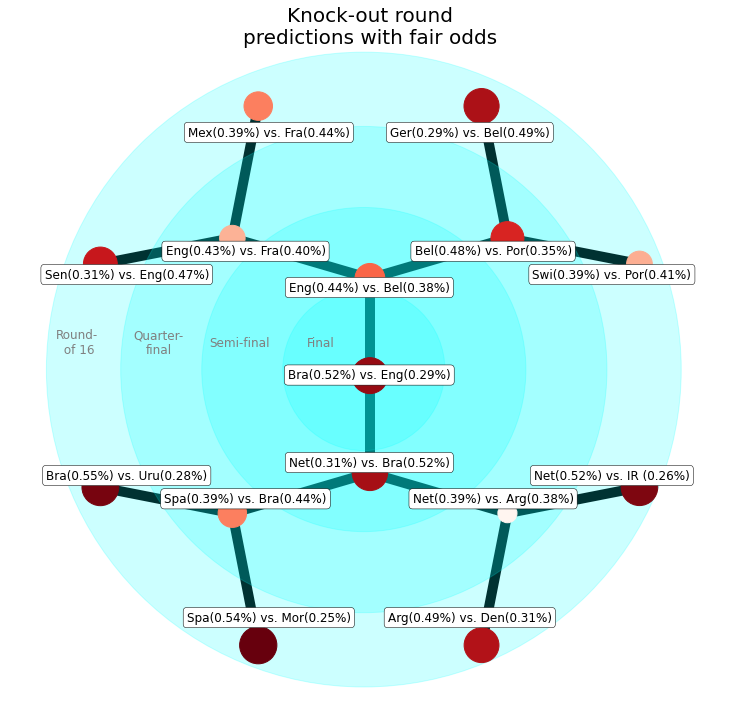

In [ ]:
import networkx as nx
import pydot
from networkx.drawing.nx_pydot import graphviz_layout

node_sizes = pd.DataFrame(list(reversed(odds)))
scale_factor = 0.3 # for visualization
G = nx.balanced_tree(2, 3)
pos = graphviz_layout(G, prog='twopi')
centre = pd.DataFrame(pos).mean(axis=1).mean()

plt.figure(figsize=(13, 12))
ax = plt.subplot(1,1,1)
# add circles
circle_positions = [(235, 'black'), (180, 'blue'), (120, 'red'), (60, 'yellow')]
[ax.add_artist(plt.Circle((centre, centre),
                          cp, color='cyan',
                          alpha=0.2)) for cp, c in circle_positions]

# draw first the graph
nx.draw(G, pos,
        node_color=node_sizes.diff(axis=1)[1].abs().pow(scale_factor),
        node_size=node_sizes.diff(axis=1)[1].abs().pow(scale_factor)*2000,
        alpha=1,
        cmap='Reds',
        edge_color='black',
        width=10,
        with_labels=False)

# draw the custom node labels
shifted_pos = {k:[(v[0]-centre)*0.9+centre,(v[1]-centre)*0.9+centre] for k,v in pos.items()}
nx.draw_networkx_labels(G,
                        pos=shifted_pos,
                        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=.5, alpha=1),
                        labels=dict(zip(reversed(range(len(labels))), labels)))

texts = ((10, 'Round-\n of 16', 'black'), (70, 'Quarter-\nfinal', 'blue'), (130, 'Semi-final', 'red'), (190, 'Final', 'yellow'))
[plt.text(p, centre+20, t,
          fontsize=12, color='grey',
          va='center', ha='center') for p,t,c in texts]
plt.axis('equal')
plt.title('Knock-out round\npredictions with fair odds', fontsize=20)
plt.show()